In [1]:
# import pickle
import json  # 存loss, acc
# import random
import timeit
import numpy as np
import matplotlib.pyplot as plt
from abc import ABCMeta, abstractmethod
#################################################
import cv2
# import matplotlib.pyplot as plt
# import math

import os
import multiprocessing as mp
from tqdm import tqdm
# import time
#################################################
# import torch
# import torch.nn as nn
# # import torch.nn.functional as F
# import torch.optim as optim
# from torch.utils.data import TensorDataset, DataLoader
#################################################
import tensorflow as tf
# import tensorflow_addons as tfa
from model_profiler import model_profiler
from tensorflow.keras import layers
# from tensorflow.keras import losses
# from tensorflow.keras import optimizers
# from tensorflow.keras import metrics
from tensorflow.data import Dataset
print(tf.__version__)

2.6.2


In [2]:
# print("# cpus: ", os.cpu_count())
NUM_PROCESSES = 8

In [3]:
resized_train_imgs = np.load(file="./data/resized_train_imgs.npy")
resized_val_imgs = np.load(file="./data/resized_val_imgs.npy")
resized_test_imgs = np.load(file="./data/resized_test_imgs.npy")
train_label = np.load(file="./data/train_label.npy")
val_label = np.load(file="./data/val_label.npy")
test_label = np.load(file="./data/test_label.npy")

def MoveColorChannel(image: np.ndarray) -> np.ndarray:
    return np.moveaxis(image, source=2, destination=0)  # reshape (H, W, C) to (C, H, W)

with mp.Pool(processes=NUM_PROCESSES) as pool:
    resized_train_imgs = pool.map(MoveColorChannel, tqdm(resized_train_imgs))
    resized_val_imgs = pool.map(MoveColorChannel, tqdm(resized_val_imgs))
    resized_test_imgs = pool.map(MoveColorChannel, tqdm(resized_test_imgs))

# convert list to numpy.ndarray
resized_train_imgs = np.array(resized_train_imgs)
resized_val_imgs = np.array(resized_val_imgs)
resized_test_imgs = np.array(resized_test_imgs)
# list to numpy.ndarray
train_label = np.array(train_label)
val_label = np.array(val_label)
test_label = np.array(test_label)
# check the shape
print(resized_train_imgs.shape)
print(resized_val_imgs.shape)
print(resized_test_imgs.shape)
print()
print(train_label.shape)
print(val_label.shape)
print(test_label.shape)

X_train, Y_train, X_val, Y_val, X_test, Y_test = resized_train_imgs, train_label, \
                                                 resized_val_imgs, val_label, \
                                                 resized_test_imgs, test_label
# normalization
X_train, X_val, X_test = X_train/float(255), X_val/float(255), X_test/float(255)
X_train -= np.mean(X_train)
X_val -= np.mean(X_val)
X_test -= np.mean(X_test)

def MakeOneHot(Y, D_out):
    N = Y.shape[0]
    Z = np.zeros((N, D_out))
    Z[np.arange(N), Y] = 1
    return Z

Y_train = MakeOneHot(Y_train, 50)
Y_val = MakeOneHot(Y_val, 50)
Y_test = MakeOneHot(Y_test, 50)

100%|██████████| 450/450 [00:00<00:00, 21488.68it/s]


(63325, 3, 32, 32)
(450, 3, 32, 32)
(450, 3, 32, 32)

(63325,)
(450,)
(450,)


In [4]:
# train_dataset = Dataset.from_tensor_slices((X_train, Y_train)).shuffle(buffer_size=100, seed=42)
# val_dataset = Dataset.from_tensor_slices((X_val, Y_val)).shuffle(buffer_size=100, seed=42)
# test_dataset = Dataset.from_tensor_slices((X_test, Y_test)).shuffle(buffer_size=100, seed=42)
BATCH_SIZE = 64
# train_dataloader = train_dataset.batch(BATCH_SIZE)
# val_dataloader = val_dataset.batch(BATCH_SIZE)
# test_dataloader = test_dataset.batch(BATCH_SIZE)

In [5]:
# Define the LeNet-5 model
def lenet5():
    model = tf.keras.Sequential()

    model.add(layers.Conv2D(6, kernel_size=5, strides=1, data_format='channels_first', activation='relu', input_shape=(3, 32, 32)))
    model.add(layers.MaxPooling2D(pool_size=2, strides=2, data_format='channels_first'))

    model.add(layers.Conv2D(16, kernel_size=5, strides=1, data_format='channels_first', activation='relu'))
    model.add(layers.MaxPooling2D(pool_size=2, strides=2, data_format='channels_first'))

    model.add(layers.Flatten())

    model.add(layers.Dense(120, activation='relu'))
    model.add(layers.Dense(84, activation='relu'))
    model.add(layers.Dense(50, activation='softmax'))

    return model

# Create an instance of the LeNet-5 model
model = lenet5()

# Print the model summary
model.summary()


Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 6, 28, 28)         456       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 6, 14, 14)         0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 16, 10, 10)        2416      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 16, 5, 5)          0         
_________________________________________________________________
flatten (Flatten)            (None, 400)               0         
_________________________________________________________________
dense (Dense)                (None, 120)               48120     
_________________________________________________________________
dense_1 (Dense)              (None, 84)                1

In [6]:
# Compile the model
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-3),
              loss=tf.keras.losses.CategoricalCrossentropy(),
              metrics=['accuracy'])

# history = model.fit(train_dataloader, epochs=30, validation_data=val_dataloader, workers=8, use_multiprocessing=True)
history = model.fit(X_train, Y_train, batch_size=64, epochs=30, validation_data=(X_val, Y_val), validation_batch_size=64, workers=8, use_multiprocessing=True)

Epoch 1/30
990/990 [==============================] - 12s 9ms/step - loss: 3.4451 - accuracy: 0.1029 - val_loss: 3.2270 - val_accuracy: 0.1333
Epoch 2/30
990/990 [==============================] - 8s 8ms/step - loss: 3.1102 - accuracy: 0.1665 - val_loss: 3.0828 - val_accuracy: 0.1689
Epoch 3/30
990/990 [==============================] - 9s 9ms/step - loss: 2.9852 - accuracy: 0.1957 - val_loss: 3.0504 - val_accuracy: 0.1778
Epoch 4/30
990/990 [==============================] - 9s 9ms/step - loss: 2.9042 - accuracy: 0.2151 - val_loss: 2.9890 - val_accuracy: 0.2133
Epoch 5/30
990/990 [==============================] - 9s 9ms/step - loss: 2.8433 - accuracy: 0.2259 - val_loss: 2.9517 - val_accuracy: 0.1978
Epoch 6/30
990/990 [==============================] - 8s 8ms/step - loss: 2.7911 - accuracy: 0.2383 - val_loss: 2.9717 - val_accuracy: 0.2067
Epoch 7/30
990/990 [==============================] - 9s 9ms/step - loss: 2.7500 - accuracy: 0.2491 - val_loss: 2.9424 - val_accuracy: 0.2089
Epoch

In [7]:
# model.save("./model/tensorflow_model")

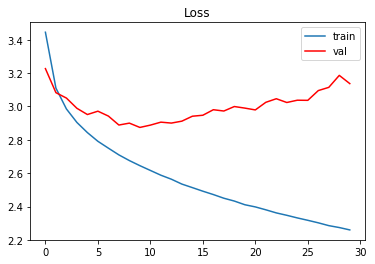

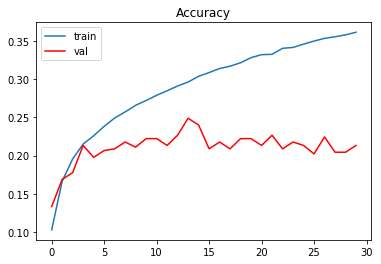

In [8]:
plt.title('Loss')
plt.plot(history.history['loss'], label="train")
plt.plot(history.history['val_loss'], label="val", c = 'red')
plt.legend()
# plt.savefig('./pic/keras_loss.png')
plt.show()

plt.title('Accuracy')
plt.plot(history.history['accuracy'], label="train")
plt.plot(history.history['val_accuracy'], label="val", c = 'red')
plt.legend()
# plt.savefig('./pic/keras_acc.png')
plt.show()

In [13]:
# predict validation set
val_history = model.evaluate(X_val, Y_val)
print(f"Test acc: {val_history[1]*100:.4f} %")

15/15 [==============================] - 0s 10ms/step - loss: 3.1371 - accuracy: 0.2133
Test acc: 21.3333 %


In [9]:
# predict test dataset
# test_history = model.evaluate(test_dataloader)
test_history = model.evaluate(X_test, Y_test)
print(f"Test acc: {test_history[1]*100:.4f} %")

15/15 [==============================] - 0s 5ms/step - loss: 3.0883 - accuracy: 0.2222
Test acc: 22.2222 %


#### compare dynamic graph and static graph

In [11]:
@tf.function
def model_training_static(x, y):
    y_prob = model(x, training=True)
    return y_prob

def model_training_dynamic(x, y):
    y_prob = model(x, training=True)
    return y_prob

print("The time on training")
print("static graph:", timeit.timeit(lambda: model_training_static(X_train, Y_train), number=1))
print("dynamic graph:", timeit.timeit(lambda: model_training_dynamic(X_train, Y_train), number=1))

The time on training
static graph: 5.522173297998961
dynamic graph: 3.1486297469818965


In [12]:
@tf.function
def model_static(x, y):
    y_prob = model(x)
    loss = tf.losses.MeanSquaredError()(y_prob, y)
    return y_prob, loss

def model_dynamic(x, y):
    y_prob = model(x)
    loss = tf.losses.MeanSquaredError()(y_prob, y)
    return y_prob, loss

print("The time on inference")
print("static graph:", timeit.timeit(lambda: model_static(X_test, Y_test), number=1))
print("dynamic graph:", timeit.timeit(lambda: model_dynamic(X_test, Y_test), number=1))

The time on inference
static graph: 0.23272970702964813
dynamic graph: 0.07180433301255107


#### compute FLOPS

In [12]:
profile = model_profiler(model, BATCH_SIZE, use_units = ['GPU IDs', 'MFLOPs', 'MB', 'Million', 'MB'])
print(profile)

| Model Profile                    | Value   | Unit    |
|----------------------------------|---------|---------|
| Selected GPUs                    | ['0']   | GPU IDs |
| No. of FLOPs                     | 0.0877  | MFLOPs  |
| GPU Memory Requirement           | 2.1459  | MB      |
| Model Parameters                 | 0.0654  | Million |
| Memory Required by Model Weights | 0.2495  | MB      |


/home/re6111032/.local/lib/python3.6/site-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


#### Network Pruning

In [14]:
from tensorflow_model_optimization.sparsity import keras as sparsity

num_epochs = 30
# num_batches = np.ceil(len(train_dataset)/BATCH_SIZE)
num_batches = np.ceil(len(X_train)/BATCH_SIZE)
pruning_params = {
    'pruning_schedule': sparsity.PolynomialDecay(
        initial_sparsity=0.50,  # Initial sparsity (50% of weights pruned)
        final_sparsity=0.90,    # Final sparsity (90% of weights pruned)
        begin_step=0,           # Step at which pruning begins
        end_step=num_epochs * num_batches,  # Step at which pruning ends
        frequency=100           # Frequency at which pruning is applied
    )
}

pruned_model = tf.keras.models.clone_model(model)
sparsity.prune_low_magnitude(pruned_model, **pruning_params)

pruned_model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
pruned_model.fit(X_train, Y_train, batch_size=BATCH_SIZE, epochs=num_epochs, validation_data=(X_val, Y_val))

final_model = sparsity.strip_pruning(pruned_model)
final_model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
test_loss, test_accuracy = final_model.evaluate(X_test, Y_test)
final_model.save('./model/pruned_model.h5')


Epoch 1/30
990/990 [==============================] - 15s 15ms/step - loss: 3.4430 - accuracy: 0.1047 - val_loss: 3.2004 - val_accuracy: 0.1244
Epoch 2/30
990/990 [==============================] - 16s 16ms/step - loss: 3.0874 - accuracy: 0.1735 - val_loss: 3.0674 - val_accuracy: 0.1822
Epoch 3/30
990/990 [==============================] - 14s 14ms/step - loss: 2.9652 - accuracy: 0.2016 - val_loss: 3.0621 - val_accuracy: 0.1756
Epoch 4/30
990/990 [==============================] - 14s 14ms/step - loss: 2.8856 - accuracy: 0.2183 - val_loss: 2.9924 - val_accuracy: 0.1711
Epoch 5/30
990/990 [==============================] - 15s 15ms/step - loss: 2.8171 - accuracy: 0.2345 - val_loss: 2.9006 - val_accuracy: 0.1911
Epoch 6/30
990/990 [==============================] - 14s 14ms/step - loss: 2.7678 - accuracy: 0.2465 - val_loss: 2.9034 - val_accuracy: 0.1911
Epoch 7/30
990/990 [==============================] - 15s 15ms/step - loss: 2.7204 - accuracy: 0.2573 - val_loss: 2.8913 - val_accuracy:

In [16]:
# predict test dataset
print(f"Test loss: {test_loss:.4f} | Test acc: {test_accuracy*100:.4f} %")

Test loss: 2.9053 | Test acc: 22.4444 %
